# Joint RV & transit fits, TOI 1199

In [140]:
# Our tools
import exoplanet as xo
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import lightkurve as lk
from astropy.io import fits
from astropy.timeseries import BoxLeastSquares
from scipy import stats

import pymc3 as pm
import aesara_theano_fallback.tensor as tt
import pymc3_ext as pmx

import os
import warnings
os.environ["MKL_THREADING_LAYER"] = "GNU"
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# %matplotlib inline

# plt.rcParams["figure.figsize"]=8,6
# plt.rcParams.update({'font.size': 16})

## Datasets and initializations
Lets start with the transits from TESS

In [141]:
plt.rcParams.update(plt.rcParamsDefault)
%matplotlib inline
plt.style.use('seaborn-dark-palette')

In [142]:
plt.rcParams["figure.figsize"]=8,6
plt.rcParams.update({'font.size': 16})

In [143]:
#sectors times, 41-48
from astropy.time import Time
sectors = ['2021-07-24T11:45:00','2021-08-20T02:05:00','2022-01-28T10:25:00','2022-02-25T11:50:00']
sectors_times = Time(sectors, format='fits')
sectors_times_btjd = sectors_times.jd-2457000
sectors_times_btjd

array([2419.98958333, 2446.58680556, 2607.93402778, 2635.99305556])

Text(0, 0.5, 'Relative flux')

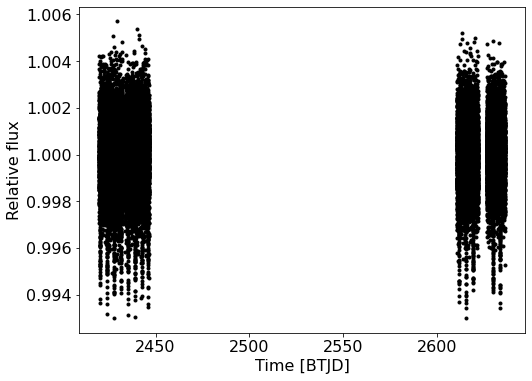

In [144]:
lc_file = lk.search_lightcurve('TIC 99869022', author='SPOC').download_all(flux_column="pdcsap_flux")
lc = lc_file.stitch().remove_nans().normalize().remove_outliers()
time = lc.time.value
flux = lc.flux


with fits.open(lc_file[0].filename) as hdu:
    hdr = hdu[1].header

texp = hdr["FRAMETIM"] * hdr["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0

ref_time = 0.5 * (np.min(time) + np.max(time))
x_ = np.ascontiguousarray(time - ref_time, dtype=np.float64)
y_ = np.ascontiguousarray(1e3 * (flux - 1.0), dtype=np.float64) # Here we convert flux to ppt
yerr_ = np.ascontiguousarray(1e3 * lc.flux_err, dtype=np.float64) 

plt.plot(time, flux, ".k")
plt.xlabel("Time [BTJD]")
plt.ylabel("Relative flux")
#_ = plt.xlim(x_.min(), x_.max())
#plt.savefig('tessdata_1199.png',dpi=300,bbox_inches='tight')

In [145]:
len(lc.flux)

32845

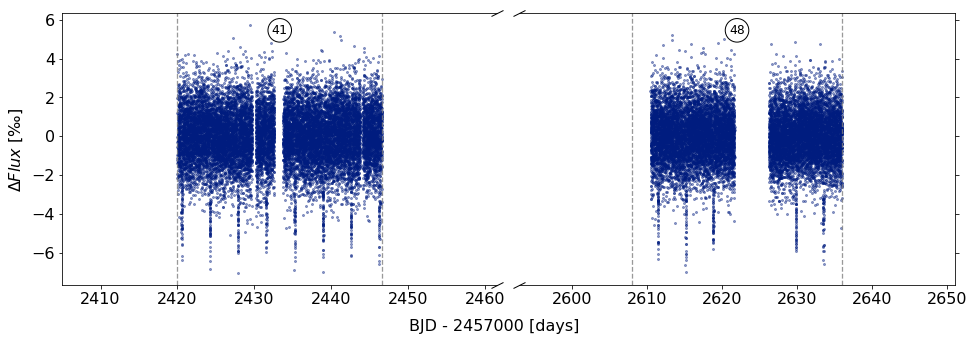

In [146]:
fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(16,5), gridspec_kw={'width_ratios': [1, 1]})
fig.subplots_adjust(wspace=0.05)
ax1.plot(time, y_, "o", markersize=2, alpha=0.4)
ax2.plot(time, y_, "o", markersize=2, alpha=0.4)
off=15
ax1.set_xlim(sectors_times_btjd[0]-off, sectors_times_btjd[1]+off)  
ax2.set_xlim(sectors_times_btjd[2]-off, sectors_times_btjd[3]+off)  
#ax2.set_xticks([2600, 2650, 2700])
ax1.spines.right.set_visible(False)
ax2.spines.left.set_visible(False)
ax1.yaxis.tick_left()
ax2.yaxis.tick_right()
ax1.tick_params(labelright=False)
ax2.tick_params(labelleft=False)

d = .5  
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([1, 1], [0, 1], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 0], [1, 0], transform=ax2.transAxes, **kwargs)
for i in sectors_times_btjd[:2]:
    ax1.axvline(x=i, color='gray', linestyle='--', linewidth=1.3, alpha=0.8)
for i in sectors_times_btjd[2:]:
    ax2.axvline(x=i, color='gray', linestyle='--', linewidth=1.3, alpha=0.8)
fig.text(0.5, 0.01, "BJD - 2457000 [days]", ha='center', va='center')
fig.text(0.085, 0.5, u'$\Delta Flux$ [‰]', ha='center', va='center', rotation='vertical')
ax1.text(sectors_times_btjd[0]+(sectors_times_btjd[1]-sectors_times_btjd[0])/2, 5.45, 
    "41", ha="center", va="center", size=13, fontfamily='monospace',
    bbox=dict(boxstyle="circle,pad=0.3", fc='white', lw=1))
ax2.text(sectors_times_btjd[2]+(sectors_times_btjd[3]-sectors_times_btjd[2])/2, 5.45, 
    "48", ha="center", va="center", size=13, fontfamily='monospace',
    bbox=dict(boxstyle="circle,pad=0.3", fc='white', lw=1))
#plt.savefig('tessdata_1199.png',dpi=300,bbox_inches='tight', facecolor='white')
plt.show()

In [147]:
period_grid = np.exp(np.linspace(np.log(1), np.log(15), 50000)) #1 y 15 -- 1 y 30
durations = np.exp(np.linspace(np.log(0.01), np.log(0.2), 100))

bls = BoxLeastSquares(x_, y_, yerr_)
bls_power = bls.power(period_grid, durations, oversample=30)

# Save the highest peak as the planet candidate
index = np.argmax(bls_power.power)
bls_period = bls_power.period[index]
bls_t0 = bls_power.transit_time[index]
bls_depth = bls_power.depth[index]
bls_duration = bls_power.duration[index]

print('bls period:',bls_period)
print('bls t0:',bls_t0)
print('bls depth:',bls_depth)
print('ref_time:', ref_time)
print('epoch:', bls_t0 + ref_time)
print('bls duration:', bls_duration)

bls period: 3.6714776169735264
bls t0: -107.44961378915842
bls depth: 3.7261476354984104
ref_time: 2527.9875009679236
epoch: 2420.5378871787652
bls duration: 0.08300000000000005


In [148]:
# 1 y 30 grid
# bls period: 3.671410300504894
# bls t0: -107.44594712249176
# bls depth: 3.7212404978662903
# ref_time: 2527.9875009679236
# epoch: 2420.5415538454317
# bls duration: 0.08300000000000005

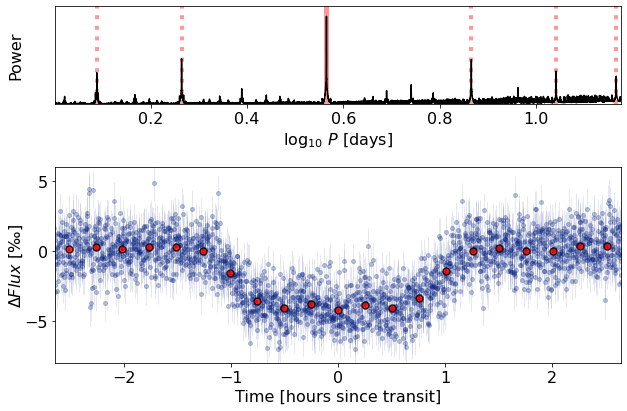

In [222]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9, 6), gridspec_kw={'height_ratios': [1, 2]})
fig.subplots_adjust(hspace=0.35)

ax1.axvline(np.log10(bls_period), color="red", lw=5, alpha=0.4)
ax1.axvline(np.log10(bls_period/2), linestyle='dotted', color="red", lw=4, alpha=0.4)
ax1.axvline(np.log10(bls_period/3), linestyle='dotted', color="red", lw=4, alpha=0.4)
#ax1.axvline(np.log10(bls_period/4), linestyle='dotted', color="red", lw=4, alpha=0.4)
ax1.axvline(np.log10(bls_period*2), linestyle='dotted', color="red", lw=4, alpha=0.4)
ax1.axvline(np.log10(bls_period*3), linestyle='dotted', color="red", lw=4, alpha=0.4)
ax1.axvline(np.log10(bls_period*4), linestyle='dotted', color="red", lw=4, alpha=0.4)
ax1.plot(np.log10(bls_power.period), bls_power.power, "k")
ax1.set_ylim(0,3500)
ax1.set_ylabel("Power", labelpad=32)
ax1.set_yticks([])
ax1.set_xlim(np.log10(period_grid.min())+0.001, np.log10(period_grid.max()))
ax1.set_xlabel(r"$\log_{10}~ P$ [days]")

# Plot the folded transit
x_fold_ = (x_ - bls_t0 + 0.5 * bls_period) % bls_period - 0.5 * bls_period
m = np.abs(x_fold_) < 0.4
ax2.plot(x_fold_*24, y_, ".", alpha=0.25, ms=8)
ax2.errorbar(x_fold_*24, y_, yerr=yerr_, fmt="none", elinewidth=1, alpha=0.1, capsize=0)

ax2.set_ylim(-8,6)
#ax2.set_ylim(-10,10)
ax2.set_yticks([-5,0,5])
# Overplot the phase binned light curve
bins = np.linspace(-0.11, 0.11, 22)
denom, _ = np.histogram(x_fold_, bins)
num, _ = np.histogram(x_fold_, bins, weights=y_)
denom[num == 0] = 1.0
binned = stats.binned_statistic(x_fold_, y_, statistic='std', bins=bins)
binned_count = stats.binned_statistic(x_fold_, y_, statistic='count', bins=bins)
ax2.errorbar((0.5 * (bins[1:] + bins[:-1]))*24, num / denom, yerr=binned.statistic/np.sqrt(binned_count.statistic), fmt='o', color='k', 
                ms=7, markeredgecolor='k', markerfacecolor='red', markeredgewidth=1.5, alpha=0.8)

ax2.set_xlim(-0.11*24, 0.11*24)
ax2.set_ylabel(u'$\Delta Flux$ [‰]', labelpad=0)
_ = ax2.set_xlabel("Time [hours since transit]")
plt.tight_layout()

#plt.savefig('bls_paper_1199.png',dpi=300,bbox_inches='tight', facecolor='white')

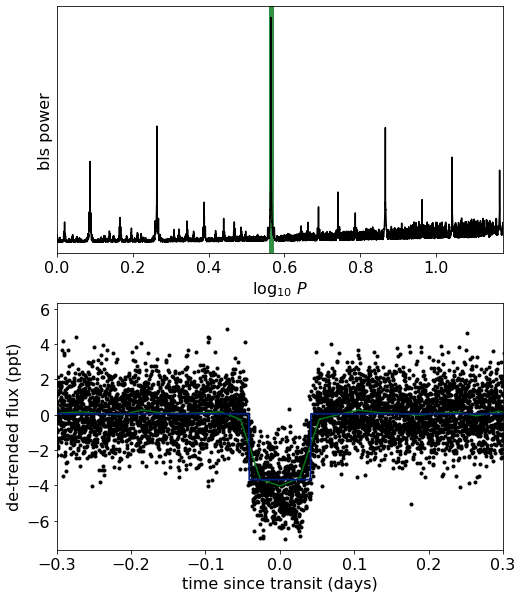

In [150]:
fig, axes = plt.subplots(2, 1, figsize=(8, 10))

# Plot the periodogram
ax = axes[0]
ax.axvline(np.log10(bls_period), color="C1", lw=5, alpha=0.8)
ax.plot(np.log10(bls_power.period), bls_power.power, "k")

ax.set_ylabel("bls power")
ax.set_yticks([])
ax.set_xlim(np.log10(period_grid.min()), np.log10(period_grid.max()))
ax.set_xlabel(r"$\log_{10}~ P$")
#ax.set_xlabel('log10 (period)')

# Plot the folded transit
ax = axes[1]
x_fold_ = (x_ - bls_t0 + 0.5 * bls_period) % bls_period - 0.5 * bls_period
m = np.abs(x_fold_) < 0.4
ax.plot(x_fold_, y_, ".k")

# Overplot the phase binned light curve
bins = np.linspace(-0.41, 0.41, 32)
denom, _ = np.histogram(x_fold_, bins)
num, _ = np.histogram(x_fold_, bins, weights=y_)
denom[num == 0] = 1.0
ax.plot(0.5 * (bins[1:] + bins[:-1]), num / denom, color="C1")

ax.set_xlim(-0.3, 0.3)
ax.set_ylabel("de-trended flux (ppt)")
_ = ax.set_xlabel("time since transit (days)")

# Over-plot the best fit model
x = np.linspace(-0.3, 0.3, 1000)
f = bls.model(x + bls_t0, bls_period, bls_duration, bls_t0)
ax.plot(x, f, lw=1.75)

#plt.savefig('bls_1199.png',dpi=200,bbox_inches='tight')

(-0.12, 0.12)

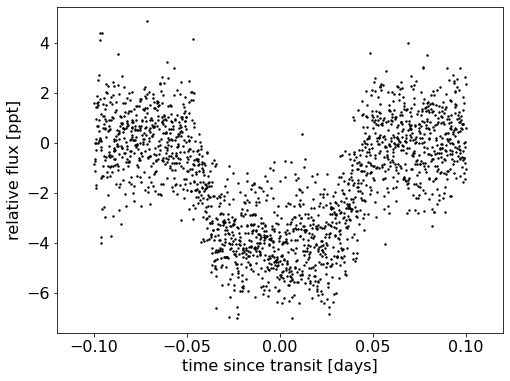

In [151]:
transit_mask = bls.transit_mask(x_, bls_period, 0.2, bls_t0)
x_fold_ = (x_ - bls_t0 + 0.5*bls_period) % bls_period - 0.5*bls_period

# Me quedo solo con los puntos cerca de los transitos
x_fold = x_fold_[transit_mask]
x = x_[transit_mask]
y = y_[transit_mask]
yerr = yerr_[transit_mask]

plt.scatter(x_fold, y, c='k', s=2)
plt.xlabel("time since transit [days]")
plt.ylabel("relative flux [ppt]");
plt.xlim(-0.12,0.12)

Now the SOPHIE RVs.

52


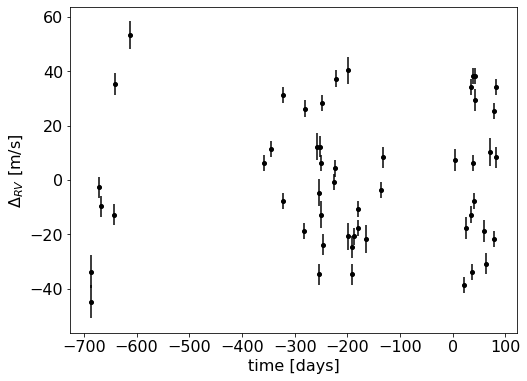

In [152]:
data = pd.read_table('1199_preliminary_rv_sophie.dat', sep='\s+')
data.rename(columns={'rv(km/s)': 'rv', 'sigRV(km/s)':'err'}, inplace=True)

x_rv = np.array(data.bjd-2457000)-ref_time
y_rv = np.array((data.rv-data.rv.mean())*1000)
yerr_rv = np.array(data.err*1000)

plt.errorbar(x_rv, y_rv, yerr=yerr_rv, fmt=".k", markersize=8)
plt.xlabel("time [days]")
print(len(x_rv))
_ = plt.ylabel("$\Delta_{RV}$ [m/s]")

In [153]:
y_rv.std()

24.60993779881522

In [154]:
# Compute a reference time that will be used to normalize the trends model
x_ref = 0.5 * (x_rv.min() + x_rv.max())

# We know the period and transit epoch from the BLS from TESS data
# let's estimate the expected semi-amplitude K for the planet

#period from exofop 3.6714634 +- 0.000004
#t0 from exofop: 2459618.796703 +- 0.0006
K = xo.estimate_semi_amplitude(bls_period, x_rv, y_rv, yerr_rv, t0s=bls_t0)
print(K, "m/s")

# Stellar parameters from Sousa
M_star = 1.18, 0.02
R_star = 1.45, 0.05

[30.00705409] m/s


Finally, using this stellar mass, we can also estimate the minimum masses of the planets given these transit parameters.

In [155]:
import exoplanet as xo
import astropy.units as u

msini = xo.estimate_minimum_mass(bls_period, x_rv, y_rv, yerr_rv, t0s=bls_t0, m_star=M_star[0])
msini = msini.to(u.M_earth)
print(msini)

[80.83506759] earthMass


In [156]:
0.5*np.log(bls_depth * 1e-3)

-2.796190192266963

## Joint transit and radial velocity model in PyMC3

Now, let's define our full model in *PyMC3*.

In [208]:
# These arrays are used as the times/phases where the models are
# evaluated at higher resolution for plotting purposes 
t_rv = np.linspace(x_rv.min() - 5, x_rv.max() + 5, 3000)
phase_lc = np.linspace(-0.3, 0.3, 150)


def build_model(mask=None, start=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)
    with pm.Model() as model:
        
        # Parameters for the stellar properties
        mean = pm.Normal("mean", mu=0.0, sd=5.0)
        u_star = xo.QuadLimbDark("u_star")
        star = xo.LimbDarkLightCurve(u_star)

        BoundedNormal = pm.Bound(pm.Normal, lower=0, upper=3)
        m_star = BoundedNormal("m_star", mu=M_star[0], sd=M_star[1])
        r_star = BoundedNormal("r_star", mu=R_star[0], sd=R_star[1])

        # Orbital parameters for the planets
        t0 = pm.Normal("t0", mu=bls_t0, sd=1)
        log_m_pl = pm.Normal("log_m_pl", mu=np.log(msini.value[0]), sd=1)
        log_period = pm.Normal("log_period", mu=np.log(bls_period), sd=1)

        #Or sample ror directly instead of depth, because b is really close to 1
        #ror = pm.LogNormal('ror', mu=0.5*np.log(bls_depth * 1e-3), sd=1)
        log_ror = pm.Normal("log_ror", mu=0.5*np.log(bls_depth * 1e-3), sd=1)
        ror = pm.Deterministic("ror", tt.exp(log_ror))
        b = xo.ImpactParameter('b', ror)

        r_pl = pm.Deterministic("r_pl", ror * r_star)

        m_pl = pm.Deterministic("m_pl", tt.exp(log_m_pl))
        period = pm.Deterministic("period", tt.exp(log_period))

        # comentar las proximas tres lineas para versión con e=0 fixed
        ecs = pmx.UnitDisk("ecs", testval=np.array([0.01, 0.01]))
        ecc = pm.Deterministic("ecc", tt.sum(ecs**2))
        omega = pm.Deterministic("omega", tt.arctan2(ecs[1], ecs[0]))

        # RV jitter & a quadratic RV trend
        log_sigma_rv = pm.Normal("log_sigma_rv", mu=np.log(np.median(yerr_rv)), sd=1)
        trend = pm.Normal("trend", mu=0, sd=10.0 ** -np.arange(3)[::-1], shape=3)  # [2,1,0]

        # Transit jitter
        logs = pm.Uniform("logs", lower=0, upper=1,testval=np.log(np.std(y)))

        # Orbit model
        orbit = xo.orbits.KeplerianOrbit(
            r_star=r_star,
            m_star=m_star,
            period=period,
            t0=t0,
            b=b,
            m_planet=xo.units.with_unit(m_pl, msini.unit),
            ecc=ecc,
            omega=omega,
        )

        # Compute the model light curve
        light_curves = (star.get_light_curve(orbit=orbit, r=r_pl, t=x[mask], texp=texp)* 1e3)
        light_curve = tt.sum(light_curves, axis=-1) + mean
        resid = y[mask] - light_curve

        # The likelihood for the light curve
        pm.Normal("transit_obs", mu=light_curve, sd=tt.exp(logs), observed=y[mask])

        # And a function for computing the full RV model
        def get_rv_model(t, name=""):
            # First the RVs induced by the planet
            vrad = orbit.get_radial_velocity(t)
            pm.Deterministic("vrad" + name, vrad)

            # Define the background model
            A = np.vander(t - x_ref, 3) # Generate a Vandermonde matrix with t-x_ref as input vector
            bkg = pm.Deterministic("bkg" + name, tt.dot(A, trend))

            # Sum planet and background to get the full model
            return pm.Deterministic("rv_model" + name, vrad + bkg)


        # Define the model
        rv_model = get_rv_model(x_rv)
        get_rv_model(t_rv, name="_pred")

        # The likelihood for the RVs
        err = tt.sqrt(yerr_rv**2 + tt.exp(2 * log_sigma_rv))
        pm.Normal("obs", mu=rv_model, sd=err, observed=y_rv)

        # Compute and save the phased light curve models
        pm.Deterministic("lc_pred",
            1e3 * star.get_light_curve(orbit=orbit, r=r_pl, t=t0 + phase_lc, texp=texp)[..., 0],)

        # Fit for the maximum a posteriori parameters
        if start is None:
            start = model.test_point
        map_soln = pmx.optimize(start=start)
        map_soln = pmx.optimize(start=map_soln)

        extras = pmx.eval_in_model(light_curves, map_soln)

    return model, map_soln, extras

model0, map_soln0, extras0 = build_model()

optimizing logp for variables: [logs, trend, log_sigma_rv, b, log_ror, log_period, log_m_pl, t0, r_star, m_star, u_star, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: -4438.440576318726 -> -3370.788754612871
optimizing logp for variables: [logs, trend, log_sigma_rv, b, log_ror, log_period, log_m_pl, t0, r_star, m_star, u_star, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: -3370.788754612871 -> -3370.788754612871


Now let's plot the map radial velocity model.

In [209]:
model0.free_RVs

[mean ~ Normal,
 u_star_quadlimbdark__ ~ TransformedDistribution,
 m_star_interval__ ~ TransformedDistribution,
 r_star_interval__ ~ TransformedDistribution,
 t0 ~ Normal,
 log_m_pl ~ Normal,
 log_period ~ Normal,
 log_ror ~ Normal,
 b_impact__ ~ TransformedDistribution,
 log_sigma_rv ~ Normal,
 trend ~ Normal,
 logs_interval__ ~ TransformedDistribution]

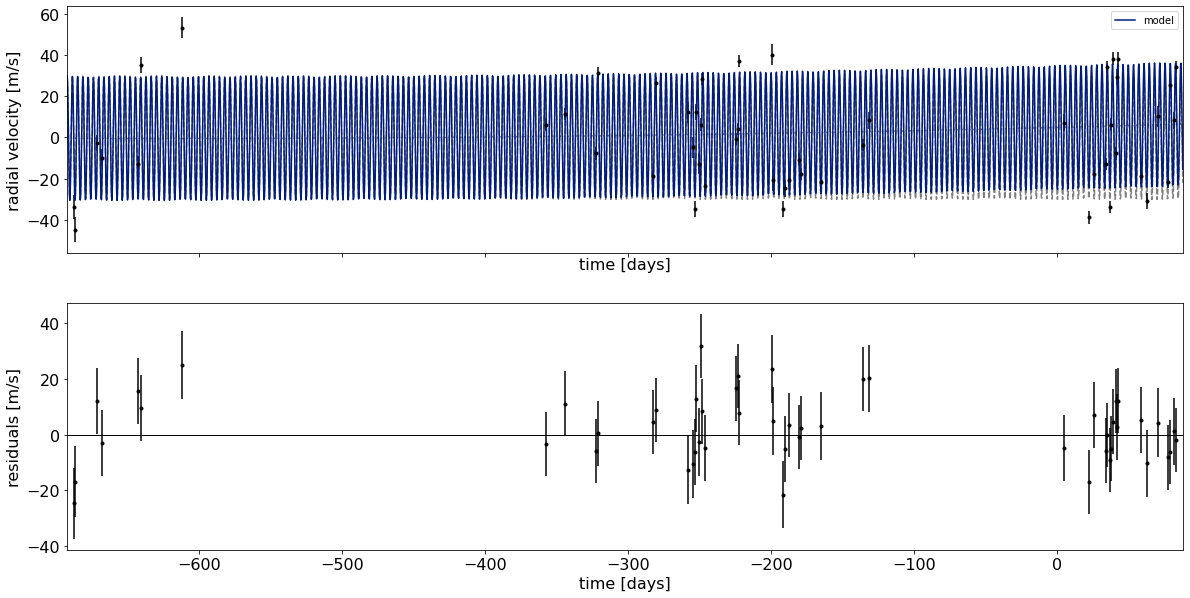

In [210]:
# We plot the initial model:
def plot_rv_curve(soln):
    fig, axes = plt.subplots(2, 1, figsize=(20, 10), sharex=True)
    ax = axes[0]
    ax.errorbar(x_rv, y_rv, yerr=yerr_rv, fmt=".k")
    ax.plot(t_rv, soln['vrad_pred'], "--k", alpha=0.5)
    ax.plot(t_rv, soln['bkg_pred'], ":k", alpha=0.5)
    ax.plot(t_rv, soln['rv_model_pred'], label="model")
    ax.legend(fontsize=10)
    ax.set_xlabel("time [days]")
    ax.set_ylabel("radial velocity [m/s]")
    
    ax = axes[1]
    err = np.sqrt(yerr_rv**2 + np.exp(2 * soln["log_sigma_rv"]))
    ax.errorbar(x_rv, y_rv - soln["rv_model"], yerr=err, fmt=".k")
    ax.axhline(0, color="k", lw=1)
    ax.set_ylabel("residuals [m/s]")
    ax.set_xlim(t_rv.min(), t_rv.max())
    #ax.set_xlim(2200,2300)
    ax.set_xlabel("time [days]")

_ = plot_rv_curve(map_soln0)

Now let's also plot the transit model.

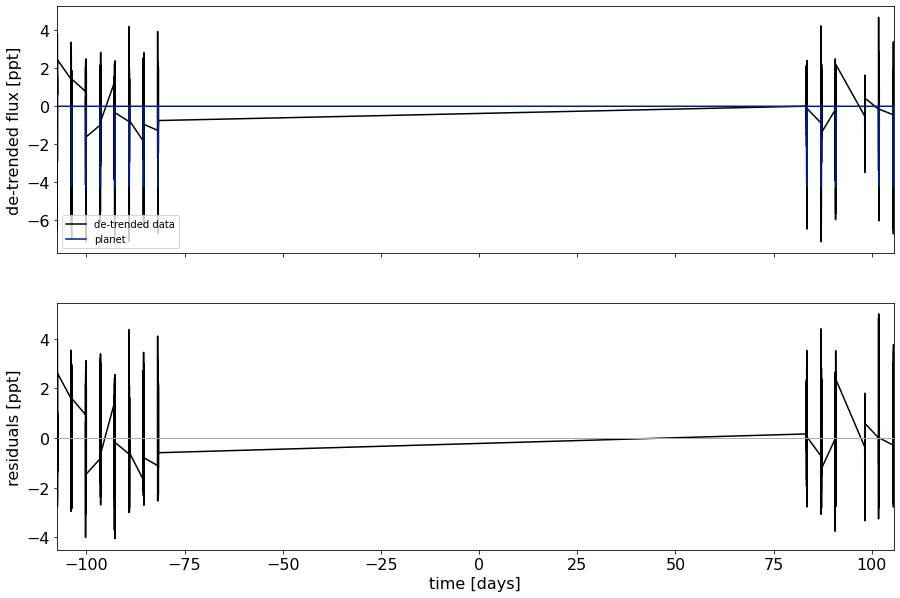

In [211]:
# We plot the initial light curve model:
def plot_light_curve(soln, extras, mask=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)

    fig, axes = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

    ax = axes[0]
    ax.plot(x[mask], y[mask] - soln['mean'], "k", label="de-trended data")
    mod = extras
    ax.plot(x[mask], mod, label="planet")
    ax.legend(fontsize=10, loc=3)
    ax.set_ylabel("de-trended flux [ppt]")

    ax = axes[1]
    mod = np.sum(extras, axis=-1)
    ax.plot(x[mask], y[mask] - mod, "k")
    ax.axhline(0, color="#aaaaaa", lw=1)
    ax.set_ylabel("residuals [ppt]")
    ax.set_xlim(x[mask].min(), x[mask].max())
    ax.set_xlabel("time [days]")
    #plt.xlim(-93,-92)
    return fig


_ = plot_light_curve(map_soln0, extras0)

## Sigma clipping

To remove the outliers, we'll look at the empirical RMS of the residuals away from the transit model and remove anything that is more than a 7-sigma outlier.

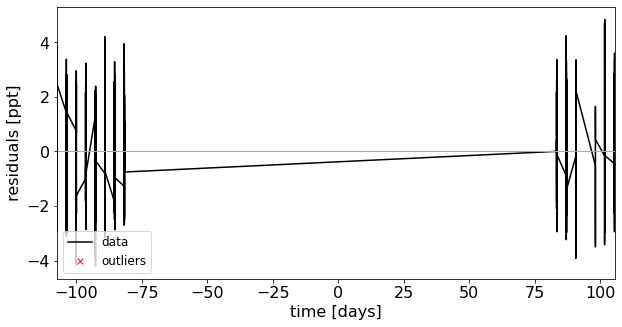

In [212]:
# We can do some sigma clipping to remove significant outliers.
mod = (map_soln0["mean"] + np.sum(extras0, axis=-1))

resid = y - mod
rms = np.sqrt(np.median(resid**2))
mask = np.abs(resid) < 7 * rms

plt.figure(figsize=(10, 5))
plt.plot(x, resid, "k", label="data")
plt.plot(x[~mask], resid[~mask], "xr", label="outliers")
plt.axhline(0, color="#aaaaaa", lw=1)
plt.ylabel("residuals [ppt]")
plt.xlabel("time [days]")
plt.legend(fontsize=12, loc=3)
_ = plt.xlim(x.min(), x.max())
#plt.xlim(-450,-435)

Let's re-build our model with this sigma-clipped dataset.

optimizing logp for variables: [logs, trend, log_sigma_rv, b, log_ror, log_period, log_m_pl, t0, r_star, m_star, u_star, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: -3370.788754612871 -> -3370.788754612871
optimizing logp for variables: [logs, trend, log_sigma_rv, b, log_ror, log_period, log_m_pl, t0, r_star, m_star, u_star, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: -3370.788754612871 -> -3370.788754612871


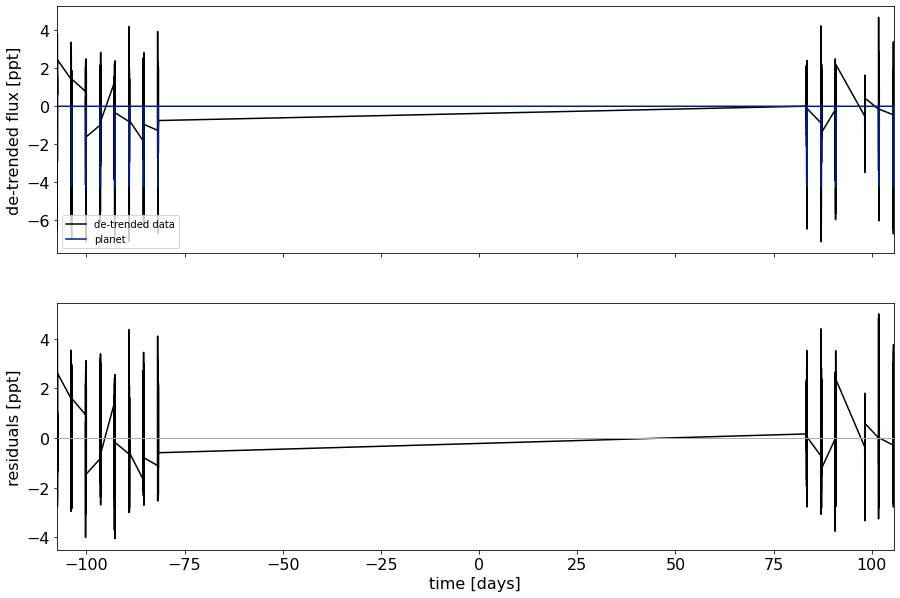

In [213]:
# looks like we don't have any outliers 
model, map_soln, extras = build_model(mask, map_soln0)
_ = plot_light_curve(map_soln, extras, mask)

Great! Now we're ready to sample.

## Sampling

In [214]:
import multiprocessing

with model:
    trace = pmx.sample(
        tune=4000, #1500,
        draws=4000, #1000,
        start=map_soln,
        cores=4, #4
        chains=2,
        target_accept=0.95,
        return_inferencedata=True,
        random_seed=[203771098, 203775000],#, 261136679, 261136680],
        init="adapt_full",
    )

Multiprocess sampling (2 chains in 4 jobs)
NUTS: [logs, trend, log_sigma_rv, b, log_ror, log_period, log_m_pl, t0, r_star, m_star, u_star, mean]


Sampling 2 chains for 4_000 tune and 4_000 draw iterations (8_000 + 8_000 draws total) took 583 seconds.


In [215]:
import arviz as az
# version con e libre
#az.to_netcdf(trace, 'trace.toi1199.save')
trace = az.from_netcdf('trace.toi1199.save')

# version con e=0 fixed
#az.to_netcdf(trace, 'trace.toi1199_noecc.save')
#trace = az.from_netcdf('trace.toi1199_noecc.save')

'trace.toi1199_noecc.save'

Let's look at the convergence diagnostics for some of the key parameters:

In [216]:
import arviz as az

az.summary(
    trace, stat_funcs={'median': np.median, 'std':np.std}, round_to=6,
    var_names=[
        'logs',
        'trend',
        'log_sigma_rv',
        'log_ror', # log_ror or log_depth
        'b',
        'log_period',
        'log_m_pl',
        't0',
        'r_star',
        'm_star',
        'u_star',
        'mean',
        'period',
        "r_pl",
        "m_pl",
        'ror',
        'ecs',
        "ecc",
        "omega"
    ],
)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,median,std
logs,0.252860,0.016482,0.221247,0.282381,0.000132,0.000094,15483.729555,5609.059126,0.999890,0.253062,0.016481
trend[0],0.000014,0.000023,-0.000030,0.000058,0.000000,0.000000,12415.100422,5350.792605,0.999937,0.000014,0.000023
trend[1],0.008956,0.007537,-0.005754,0.022267,0.000066,0.000063,13083.092647,6039.177091,1.000072,0.008865,0.007537
trend[2],0.884475,0.956606,-0.884385,2.695042,0.008218,0.009293,13522.882160,5633.888079,1.000171,0.884803,0.956547
log_sigma_rv,2.456712,0.112186,2.256526,2.675905,0.001006,0.000714,12453.071452,6074.935257,0.999847,2.455366,0.112179
log_ror,-2.702849,0.020741,-2.739153,-2.662533,0.000348,0.000246,3514.672651,3505.692903,1.000230,-2.704383,0.020740
b,0.853707,0.012613,0.829550,0.876664,0.000170,0.000120,5784.735363,4324.368218,1.003242,0.854729,0.012612
log_period,1.300591,0.000004,1.300584,1.300598,0.000000,0.000000,12389.934984,5367.812165,1.000292,1.300591,0.000004
log_m_pl,4.390683,0.085210,4.227549,4.547292,0.000808,0.000571,11645.013987,5351.536121,1.001433,4.394196,0.085205
t0,-107.449740,0.000462,-107.450566,-107.448836,0.000004,0.000003,11691.226084,5885.445284,1.000683,-107.449744,0.000462


In [217]:
from uncertainties import ufloat
from uncertainties.umath import *

logsigma_rv_median = trace.posterior["log_sigma_rv"].median().item()
logsigma_rv = ufloat(logsigma_rv_median, trace.posterior["log_sigma_rv"].std().item())
rv_jitter_ = np.e**logsigma_rv
print(rv_jitter_)

11.7+/-1.3


In [218]:
radio = (trace.posterior["r_pl"].median().item()*u.R_sun).to(u.R_jup).value
radio_err = (trace.posterior["r_pl"].std().item()*u.R_sun).to(u.R_jup).value
masa = (trace.posterior["m_pl"].median().item()*u.M_earth).to(u.M_jup).value
masa_err = (trace.posterior["m_pl"].std().item()*u.M_earth).to(u.M_jup).value
periodo = trace.posterior['period'].median().item()
periodo_sigma = trace.posterior['period'].std().item()
t_0 = trace.posterior['t0'].mean().item()+ref_time
t_0_sigma = trace.posterior['t0'].std().item()
G = 6.6743e-11
teff = ufloat(5700,66)
smaxis = ((ufloat(periodo*u.day.to(u.second),periodo_sigma*u.day.to(u.second)))**2*G*(ufloat(trace.posterior['m_star'].median().item()*u.M_sun.to(u.kg), trace.posterior['m_star'].std().item()*u.M_sun.to(u.kg))+
            ufloat(masa*u.M_jup.to(u.kg), masa_err*u.M_jup.to(u.kg)))/(4*np.pi**2))**(1/3)*u.m.to(u.au)
teq = teff*(ufloat(trace.posterior['r_star'].median().item()*u.R_sun.to(u.au), trace.posterior['r_star'].std().item()*u.R_sun.to(u.au))/smaxis)**(1/2)*(1/4)**(1/4)
print("Radio = {r:.3f} \u00B1 {r_err:.3f} Rj".format(r=radio, r_err=radio_err))
print("Masa = {m:.3f} \u00B1 {m_err:.3f} Mj".format(m=masa, m_err=masa_err))
print("Periodo = {p:.6f} \u00B1 {p_s:.6f}".format(p=periodo, p_s=periodo_sigma))
print("Epoca = {e:.5f} \u00B1 {e_s:.4f}".format(e=t_0, e_s=t_0_sigma))
print('Semieje mayor= {s:.4f} au'.format(s=smaxis))
print('Temperatura de equilibrio= {t:.3f} K'.format(t=teq))

Radio = 0.940 ± 0.033 Rj
Masa = 0.255 ± 0.021 Mj
Periodo = 3.671465 ± 0.000014
Epoca = 2420.53776 ± 0.0005
Semieje mayor= 0.0492+/-0.0003 au
Temperatura de equilibrio= 1487.916+/-28.124 K


In [ ]:
# resultados con e=0
# Radio = 0.940 ± 0.033 Rj
# Masa = 0.255 ± 0.021 Mj
# Periodo = 3.671465 ± 0.000014
# Epoca = 2420.53776 ± 0.0005
# Semieje mayor= 0.0492+/-0.0003 au
# Temperatura de equilibrio= 1487.916+/-28.124 K

In [ ]:
# resultados con e libre
# Radio = 0.951 ± 0.037 Rj
# Masa = 0.260 ± 0.021 Mj
# Periodo = 3.671466 ± 0.000013
# Epoca = 2420.53754 ± 0.0005
# Semieje mayor= 0.0492+/-0.0003 au
# Temperatura de equilibrio= 1498.117+/-29.783 K


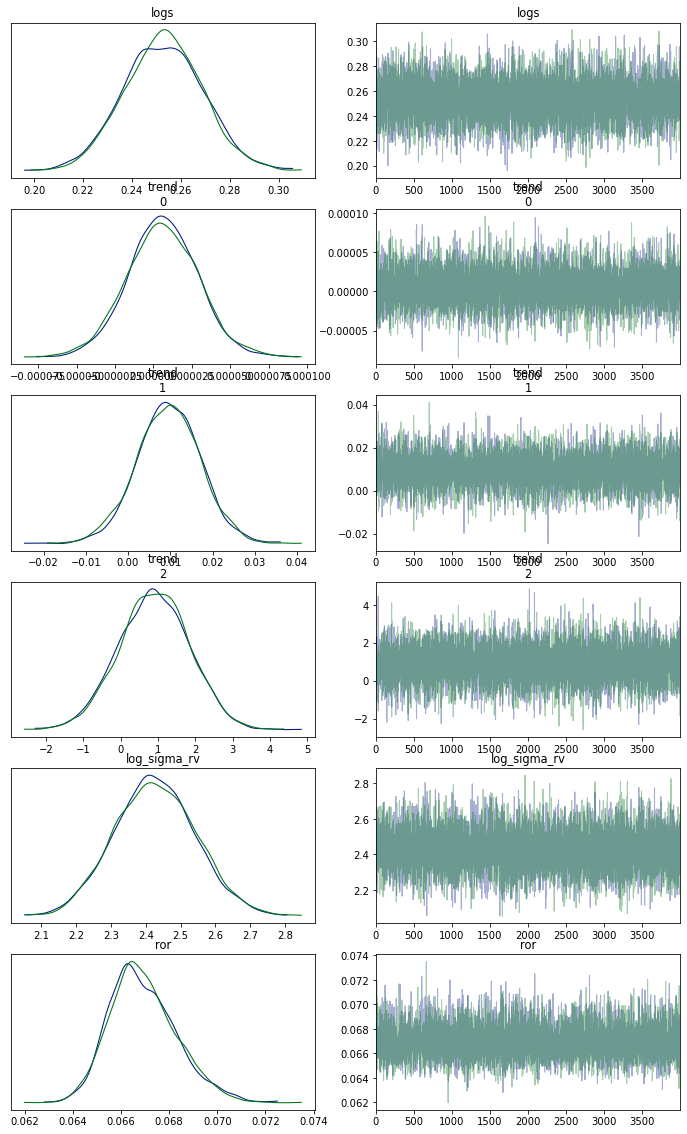

In [168]:
from arviz.utils import Numba
Numba.disable_numba()
Numba.numba_flag

_ = az.plot_trace(trace, var_names=['logs', 'trend','log_sigma_rv', 'ror'] #log_depth or log_ror
                                    , compact=False, figsize=(12,20)) # SAMPLED 1 #ror instead of log_depth
# _ = az.plot_trace(trace, var_names=['log_period', 'log_m_pl', 't0', 'r_star', 'm_star']
#                                    , compact=False, figsize=(12,20)) # SAMPLED 2
# _ = az.plot_trace(trace, var_names=['ecs', 'b', 'u_star', 'mean']
#                                    , compact=False, figsize=(12,25)) # SAMPLED 3
# plt.savefig('trace_joint_1199_1.png',dpi=200,bbox_inches='tight')

In [169]:
trace3 = trace.copy()
trace3.posterior['r_pl'] = trace3.posterior['r_pl']*9.73116

In [170]:
CORNER_KWARGS = dict(
    smooth=0.9,
    plot_density=False,
    plot_datapoints=False,
    fill_contours=True,
    #levels=(1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.)),
    levels=(0.16,0.5,0.84),
    max_n_ticks=3
)

<Figure size 1008x1008 with 0 Axes>

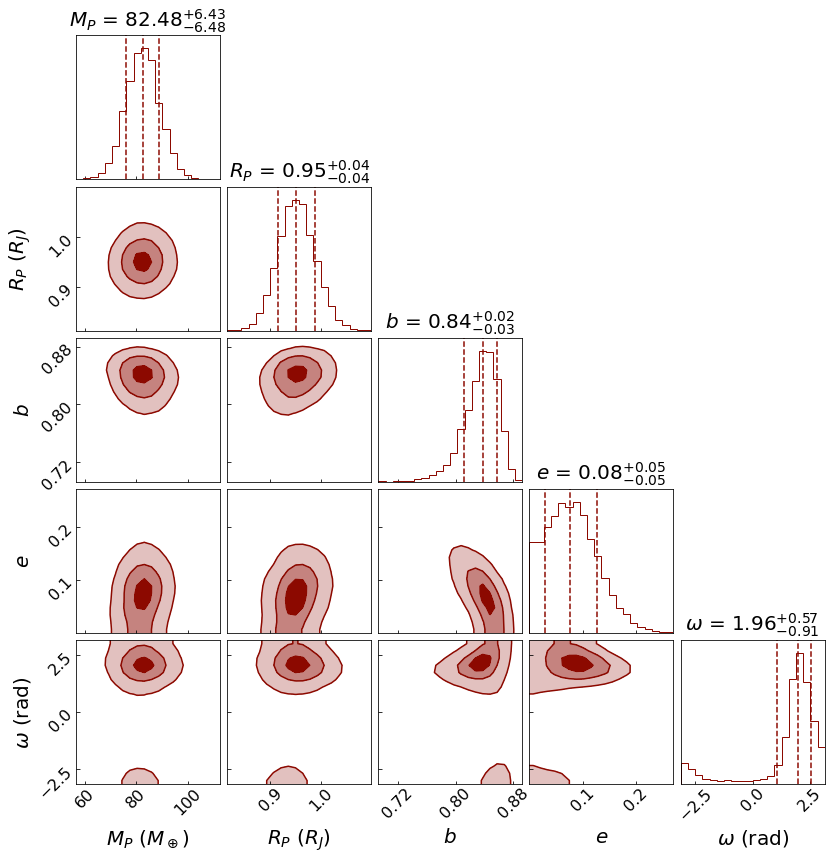

In [207]:
from cProfile import label
import corner
plt.figure(figsize=(14,14))
figure = corner.corner(trace3, var_names=['m_pl', 'r_pl', 'b', 'ecc', 'omega'],#, 'omega'], 
                        labels=[r"$M_P ~(M_\oplus)$", r"$R_P ~(R_{J})$", r"$b$", r"$e$", r"$\omega$ (rad)"], label_kwargs={'fontsize':20},#, r"$\omega$ (rad)"],
                        show_titles=True, title_kwargs={'fontsize':20, 'pad':9.0}, titles=['$M_P$','$R_P$','$b$','$e$', '$\omega$'], divergences=True, plot_contours=True,
                        labelpad=0, color='C2', quantiles=[0.16, 0.5, 0.84], **CORNER_KWARGS) #, quantiles=[0.16, 0.5, 0.84],
for ax in figure.get_axes():
    ax.tick_params(axis='both', pad=1, direction='in', labelbottom=True, labelleft=True, left=True, bottom=True)
#plt.savefig('corner_1199.png',dpi=300,bbox_inches='tight')
plt.show()

## Phase plots

In [172]:
flat_samps = trace.posterior.stack(sample=("chain", "draw"))

# Get the posterior median orbital parameters
p_ = np.median(flat_samps["period"])
t0_ = np.median(flat_samps["t0"])
mean = np.median(flat_samps["mean"])

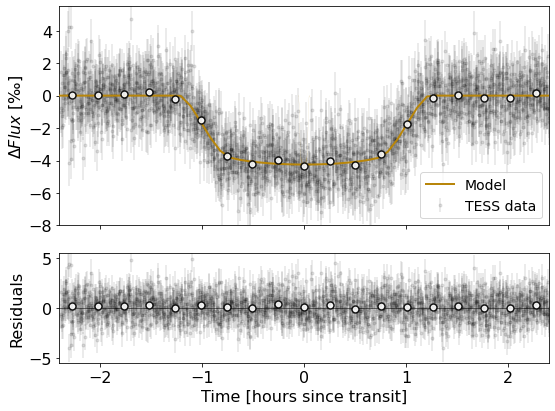

In [195]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), sharex=True, gridspec_kw={'height_ratios': [2,1]})
# Plot the folded data
x_fold2 = (x[mask] - t0_ + 0.5 * p_) % p_ - 0.5 * p_
#ax1.plot(x_fold2*24, y[mask] - mean, ".k", label="TESS data", zorder=-1000, alpha=0.15)
ax1.errorbar(x_fold2*24, y[mask] - mean, yerr=yerr[mask], fmt=".k", label="TESS data", capsize=0, zorder=-1000, alpha=0.1)
# Overplot the phase binned light curve
bins = np.linspace(-0.10, 0.10, 20)
denom, _ = np.histogram(x_fold2, bins)
num, _ = np.histogram(x_fold2, bins, weights=y[mask] - mean)
denom[num == 0] = 1.0
binned = stats.binned_statistic(x_fold2, y[mask] - mean, statistic='std', bins=bins)
binned_count = stats.binned_statistic(x_fold2, y[mask] - mean, statistic='count', bins=bins)
ax1.errorbar((0.5 * (bins[1:] + bins[:-1]))*24, num / denom, yerr=binned.statistic/np.sqrt(binned_count.statistic), fmt='o', color='k', 
                ms=7, markeredgecolor='k', markerfacecolor='white', markeredgewidth=1.5, alpha=0.9, zorder=900)
# Plot the model
pred = np.percentile(flat_samps["lc_pred"], [16, 50, 84], axis=-1)
ax1.plot(phase_lc*24, pred[1], color="C4", label="Model", zorder=800, linewidth=2)
art = ax1.fill_between(phase_lc, pred[0], pred[2], color="C4", alpha=0.5, zorder=800)
art.set_edgecolor("none")

ax1.legend(fontsize=14, loc=4)
ax1.set_ylabel(u'$\Delta Flux$ [‰]')
ax1.set_xlim(-0.10*24, 0.10*24)
ax1.set_ylim(-8,5.5)
ax1.set_yticks([-8, -6,-4,-2,0,2,4])

ax2.axhline(y=0, color='k', linewidth=1, alpha=0.5)
#ax2.plot(x_fold2*24, y[mask] - np.sum(extras, axis=-1), ".k", label="data", zorder=-1000, alpha=0.15)
ax2.errorbar(x_fold2*24, y[mask] - np.sum(extras, axis=-1), yerr=yerr[mask], label="data", fmt=".k", capsize=0, zorder=-1000, alpha=0.1)
# Overplot the phase binned residuals
num, _ = np.histogram(x_fold2, bins, weights=y[mask] - np.sum(extras, axis=-1))
denom[num == 0] = 1.0
binned = stats.binned_statistic(x_fold2, y[mask] - np.sum(extras, axis=-1), statistic='std', bins=bins)
binned_count = stats.binned_statistic(x_fold2, y[mask] - np.sum(extras, axis=-1), statistic='count', bins=bins)
ax2.errorbar((0.5 * (bins[1:] + bins[:-1]))*24, num / denom, yerr=binned.statistic/np.sqrt(binned_count.statistic), fmt='o', color='k', 
                ms=7, markeredgecolor='k', markerfacecolor='white', markeredgewidth=1.5, alpha=0.9, zorder=900)
ax2.set_ylabel('Residuals', family='sans')
ax2.set_xlabel("Time [hours since transit]")
ax2.set_ylim(-5.5,5.5)
plt.tight_layout()
#plt.savefig('fit_transit_joint_1199.png',dpi=300,bbox_inches='tight', facecolor='white')

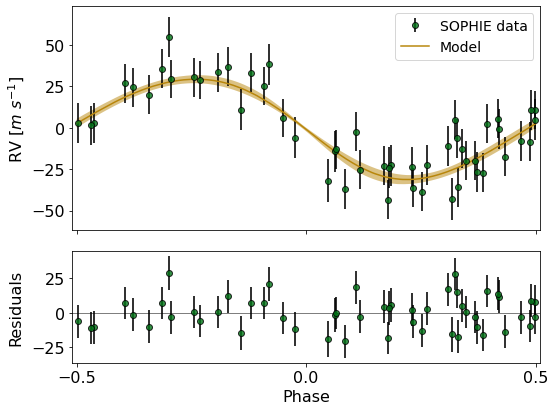

In [174]:
rv_jitter = np.exp(np.median(flat_samps['log_sigma_rv']))
bkg_ = np.median(flat_samps['bkg'].values, axis=-1)
rv_model_ = np.median(flat_samps['rv_model'].values, axis=-1)

# Plot the folded data
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), sharex=True, gridspec_kw={'height_ratios': [2,1]})
x_fold = (x_rv - t0_ + 0.5 * p_) % p_ - 0.5 * p_
#ax1.plot(x_fold, y_rv - bkg_,".k", label='SOPHIE data')
ax1.errorbar(x_fold/p_, y_rv - bkg_, yerr=np.sqrt(yerr_rv**2+rv_jitter**2), fmt="o", color='C1', 
            markeredgecolor='k', ecolor='k', elinewidth=2, label='SOPHIE data', alpha=0.8)
#ax1.set_ylim(-70,70)

# Compute the posterior prediction for the folded RV model 
t_fold = (t_rv - t0_ + 0.5 * p_) % p_ - 0.5 * p_
inds = np.argsort(t_fold)
pred = np.percentile(trace.posterior["vrad_pred"].values[:, :, inds],[16, 50, 84],axis=(0, 1),)
ax1.plot(t_fold[inds]/p_, pred[1], color="C4", label="Model")
art = ax1.fill_between(t_fold[inds]/p_, pred[0], pred[2], color="C4", alpha=0.5)
art.set_edgecolor("none")
#ax1.set_xlim(-0.5 * p_, 0.5 * p_)
ax1.set_xlim(-0.51, 0.51)
ax1.set_ylabel("RV [$m~s^{-1}$]")
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles[::-1], labels[::-1], fontsize=14, loc='best')

# Plot the folded residuals
ax2.axhline(y=0, color='k', linewidth=1, alpha=0.5)
ax2.errorbar(x_fold/p_, y_rv-rv_model_ - bkg_, yerr=np.sqrt(yerr_rv**2+rv_jitter**2), fmt="o", color='C1',
            markeredgecolor='k', ecolor='k', elinewidth=2, alpha=0.8, label='residuals')
ax2.set_ylabel('Residuals', labelpad=8)
ax2.set_xlabel("Phase")
ax2.set_xlim(-0.51, 0.51)
ax2.set_xticks([-0.5, 0, 0.5])
plt.tight_layout()
#plt.savefig('fit_rv_joint_1199.png',dpi=300,bbox_inches='tight', facecolor='white')

In [175]:
from uncertainties import ufloat
from uncertainties.umath import *

rpl = ufloat((radio *u.R_jup).to(u.cm).value, (radio_err *u.R_jup).to(u.cm).value)  
mpl = ufloat((masa *u.M_jup).to(u.g).value, (masa_err *u.M_jup).to(u.g).value)

densidad = mpl * 1/(4 / 3 * np.pi * rpl**3)
print(densidad)

0.37+/-0.05


We can also compute the posterior constraints on the planet densitiy.

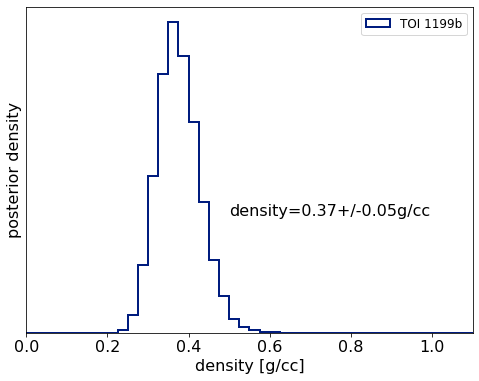

In [176]:
volume = 4 / 3 * np.pi * flat_samps["r_pl"].values ** 3
density = u.Quantity(flat_samps["m_pl"].values / volume, unit=u.M_earth / u.R_sun**3)
density = density.to(u.g / u.cm**3).value

bins = np.linspace(0, 1.1, 45)
plt.hist(
        density,
        bins,
        histtype="step",
        lw=2,
        label='TOI 1199b',
        density=True,)
plt.yticks([])
plt.legend(fontsize=12)
plt.text(0.5, 3, 'density={:.2f}+/-{:.2f}g/cc'.format(np.median(density),np.std(density)))
plt.xlim(bins[0], bins[-1])
plt.xlabel("density [g/cc]")
_ = plt.ylabel("posterior density")
#plt.savefig('density_joint_1199.png',dpi=200,bbox_inches='tight')

#### New photometry?

In [229]:
# all have the same columns
# hay que dividir los flujos por su mediana
data1 = pd.read_table('/home/juan/Documents/PAPER_TESS/data/photom/TOI1199/TIC99869022.01_UT2021.0213_KeplerCam_B.dat', sep='\s+')
data2 = pd.read_table('/home/juan/Documents/PAPER_TESS/data/photom/TOI1199/TIC99869022.01_UT2021.0413_KeplerCam_B.dat', sep='\s+')
data3 = pd.read_table('/home/juan/Documents/PAPER_TESS/data/photom/TOI1199/TIC99869022.01_UT2021.0413_KeplerCam_z.dat', sep='\s+')
data4 = pd.read_table('/home/juan/Documents/PAPER_TESS/data/photom/TOI1199/TIC99869022.01_UT2021.0413_KeplerCam_z.dat', sep='\s+')
data1.columns

Index(['#', 'Label', 'BJD_TDB', 'rel_flux_T1', 'rel_flux_err_T1', 'AIR',
       'JD_UTC'],
      dtype='object')

In [230]:
#puntos?
print('puntos:', len(data1)+len(data2)+len(data3)+len(data4))

puntos: 758


In [231]:
data1['flux'] = ((data1['rel_flux_T1']/(data1['rel_flux_T1'].median())))*1e3
data2['flux'] = ((data2['rel_flux_T1']/(data2['rel_flux_T1'].median())))*1e3
data3['flux'] = ((data3['rel_flux_T1']/(data3['rel_flux_T1'].median())))*1e3
data4['flux'] = ((data4['rel_flux_T1']/(data4['rel_flux_T1'].median())))*1e3

data1['flux_err'] = ((data1['rel_flux_err_T1']/(data1['rel_flux_T1'].median())))*1e3
data2['flux_err'] = ((data2['rel_flux_err_T1']/(data2['rel_flux_T1'].median())))*1e3
data3['flux_err'] = ((data3['rel_flux_err_T1']/(data3['rel_flux_T1'].median())))*1e3
data4['flux_err'] = ((data4['rel_flux_err_T1']/(data4['rel_flux_T1'].median())))*1e3

data1['time'] = data1['BJD_TDB']-2457000-ref_time
data2['time'] = data2['BJD_TDB']-2457000-ref_time
data3['time'] = data3['BJD_TDB']-2457000-ref_time
data4['time'] = data4['BJD_TDB']-2457000-ref_time

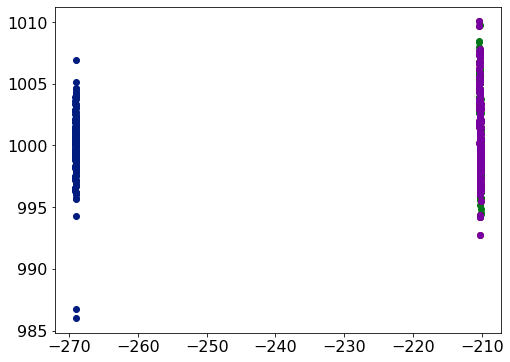

In [232]:
# Lest plot them together
plt.plot(data1['time'], data1['flux'], 'o', label='2021.0213_KeplerCam_B')
plt.plot(data2['time'], data2['flux'], 'o', label='2021.0413_KeplerCam_B')
plt.plot(data3['time'], data3['flux'], 'o', label='2021.0413_KeplerCam_z')
plt.plot(data4['time'], data4['flux'], 'o', label='2021.0413_KeplerCam_z')
#plt.xlim(-211, -210)
#plt.xlim(-269.2,-268.5)
plt.show()

In [233]:
np.std(np.concatenate((data1['flux'], data2['flux'], data3['flux'], data4['flux']), axis=None))

3.205542129344173

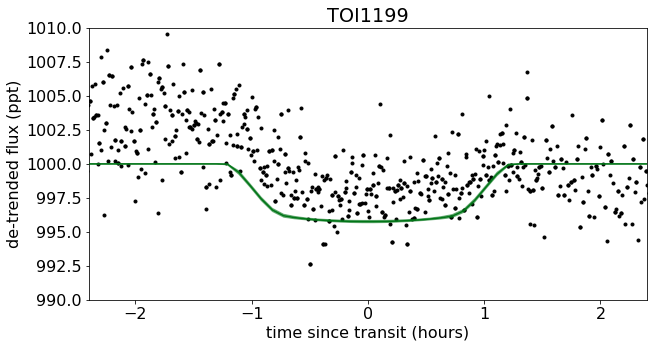

In [234]:
# Plot the folded data
data1_fold = (data1['time'] - t0_ + 0.5 * p_) % p_ - 0.5 * p_
data2_fold = (data2['time'] - t0_ + 0.5 * p_) % p_ - 0.5 * p_
data3_fold = (data3['time'] - t0_ + 0.5 * p_) % p_ - 0.5 * p_
data4_fold = (data4['time'] - t0_ + 0.5 * p_) % p_ - 0.5 * p_
plt.figure(figsize=(10, 5))
plt.plot(data1_fold*24, data1['flux'] - mean, ".k", label="data1", zorder=-1000)
plt.plot(data2_fold*24, data2['flux'] - mean, ".k", label="data2", zorder=-1000)
plt.plot(data3_fold*24, data3['flux'] - mean, ".k", label="data3", zorder=-1000)
plt.plot(data4_fold*24, data4['flux'] - mean, ".k", label="data4", zorder=-1000)

pred = np.percentile(flat_samps["lc_pred"], [16, 50, 84], axis=-1)
plt.plot(phase_lc*24, pred[1]+1000, color="C1", label="model")
plt.fill_between(phase_lc*24, pred[0]+1000, pred[2]+1000, color="C1", alpha=0.5, zorder=1000)
plt.ylabel("de-trended flux (ppt)")
plt.xlabel('time since transit (hours)')
plt.xlim(-0.10*24, 0.10*24)
plt.ylim(990,1010)
plt.title("TOI1199")
plt.savefig('new_phot_1199.png',dpi=200,bbox_inches='tight', facecolor='white')
plt.show()


In [235]:
# ajustemos un pol grado 2 a los datos oot
# mascaras para sacar los datos en transito
oot_mask1 = bls.transit_mask(data1['time'], p_, bls_duration, t0_)
oot_mask2 = bls.transit_mask(data2['time'], p_, bls_duration, t0_)
oot_mask3 = bls.transit_mask(data3['time'], p_, bls_duration, t0_)
oot_mask4 = bls.transit_mask(data4['time'], p_, bls_duration, t0_)

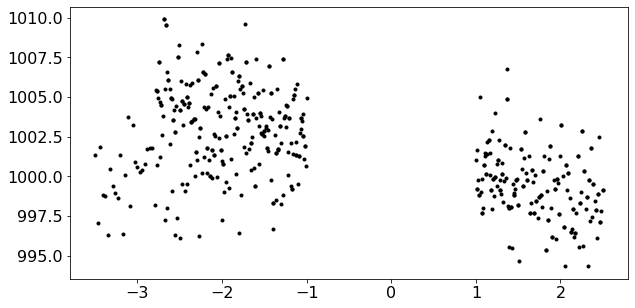

In [236]:
# checking the oot mask
plt.figure(figsize=(10, 5))
plt.plot((data1_fold*24)[~oot_mask1], data1['flux'][~oot_mask1] - mean, ".k", label="data1", zorder=-1000)
plt.plot((data2_fold*24)[~oot_mask2], data2['flux'][~oot_mask2] - mean, ".k", label="data2", zorder=-1000)
plt.plot((data3_fold*24)[~oot_mask3], data3['flux'][~oot_mask3] - mean, ".k", label="data3", zorder=-1000)
plt.plot((data4_fold*24)[~oot_mask4], data4['flux'][~oot_mask4] - mean, ".k", label="data4", zorder=-1000)


In [237]:
# fitemos un pol grado 2 a los datos oot
x_oot = np.concatenate(((data1_fold*24)[~oot_mask1], (data2_fold*24)[~oot_mask2], (data3_fold*24)[~oot_mask3]
                        ,(data4_fold*24)[~oot_mask4] ), axis=None)
y_oot = np.concatenate((data1['flux'][~oot_mask1], data2['flux'][~oot_mask2], data3['flux'][~oot_mask3]
                        ,data4['flux'][~oot_mask4] ), axis=None)
z = np.polyfit(x_oot, y_oot, 2) 
def pol(x):
    return np.asarray(z[0]*x**2 + z[1]*x + z[2])

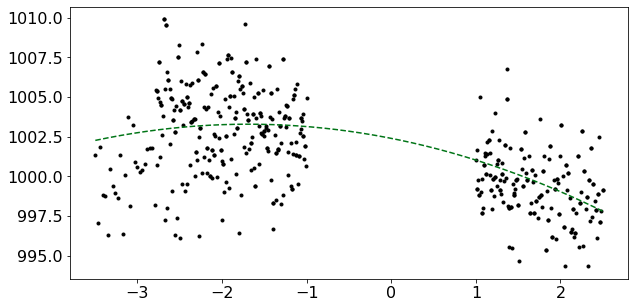

In [238]:
plt.figure(figsize=(10, 5))
plt.plot((data1_fold*24)[~oot_mask1], data1['flux'][~oot_mask1] - mean, ".k", label="data1", zorder=-1000)
plt.plot((data2_fold*24)[~oot_mask2], data2['flux'][~oot_mask2] - mean, ".k", label="data2", zorder=-1000)
plt.plot((data3_fold*24)[~oot_mask3], data3['flux'][~oot_mask3] - mean, ".k", label="data3", zorder=-1000)
plt.plot((data4_fold*24)[~oot_mask4], data4['flux'][~oot_mask4] - mean, ".k", label="data4", zorder=-1000)
x_plot = np.linspace(np.min(x_oot), np.max(x_oot), 1000)
plt.plot(x_plot, pol(x_plot), color="C1", label="model", linestyle="--")
#plt.savefig('ajuste_phot_1199.png',dpi=200,bbox_inches='tight', facecolor='white')

In [239]:
from scipy import stats

In [240]:
x_conc = np.concatenate((data1_fold*24, data2_fold*24, data3_fold*24, data4_fold*24), axis=None)
y_conc = np.concatenate(((np.asarray(data1['flux']-mean)/pol(data1_fold*24)-1)*1e3, (np.asarray(data2['flux']-mean)/pol(data2_fold*24)-1)*1e3, 
                        (np.asarray(data3['flux']-mean)/pol(data3_fold*24)-1)*1e3, (np.asarray(data4['flux']-mean)/pol(data4_fold*24)-1)*1e3), axis=None)
y_err_conc = np.concatenate((data1['flux_err'], data2['flux_err'], data3['flux_err'], data4['flux_err']), axis=None)

In [1]:
#replot dividing by polynomial
plt.figure(figsize=(8, 4))
#plot the data
plt.plot(x_conc, y_conc, '.', ms=4, color='k', label='KeplerCAM data', zorder=-1000, alpha=0.2)
plt.errorbar(x_conc, y_conc, yerr=y_err_conc, fmt="none", color='k', capsize=0, zorder=-1000, alpha=0.2)
#plot the model
pred = np.percentile(flat_samps["lc_pred"], [16, 50, 84], axis=-1)
plt.plot(phase_lc*24, pred[1], color="C4", label="Model", zorder=1000, alpha=0.7)
plt.fill_between(phase_lc*24, pred[0], pred[2], color="C4", alpha=0.5, zorder=1000)
# # Plot the binned lightcurve
#bins = np.linspace(-0.14*24, 0.10*24, 25)
bins = np.linspace(-0.11*24, 0.11*24, 22)
denom, _ = np.histogram(x_conc, bins)
num, _ = np.histogram(x_conc, bins, weights=y_conc)
denom[num == 0] = 1.0
binned = stats.binned_statistic(x_conc, y_conc, statistic='std', bins=bins)
binned_count = stats.binned_statistic(x_conc, y_conc, statistic='count', bins=bins)
plt.errorbar((0.5 * (bins[1:] + bins[:-1])), num / denom, yerr=binned.statistic/np.sqrt(binned_count.statistic*100), fmt='v', color='k', 
                ms=7, mec='k', mfc='red', mew=1, alpha=0.9, zorder=1100)
plt.legend(fontsize=14, loc=4)
plt.ylabel(u'$\Delta Flux$ [‰]')
plt.xlabel("Time [hours since transit]")
#plt.yticks([-10,-5,0,5])
plt.xlim(-0.10*24, 0.10*24)
plt.ylim(-15, 10)
plt.tight_layout()
#plt.savefig('new_phot_1199_keplercam.png',dpi=300,bbox_inches='tight', facecolor='white')
plt.show()

NameError: name 'plt' is not defined